In [1]:
# Import the necessary packages. 
# Note that you may need to install some packages, e.g., yfinance.
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import urllib.request as ur
from urllib.request import urlopen
import yfinance as yf
import numpy as np

In [2]:
#The Discounted Cash Flow (DCF) Model is one of the most commonly used methods to value equity.
#It is based on the principle that the value of any asset is equal to the present value of the cash flows that it generates in the future. 
#In this project, we will be building a DCF Model to predict the equity price of a company using Python,
#which can help people interested in finance to have an automatic and easy to use technical toolkit in 
#understanding the predicted future stock price of a company. - make this into title and intro

In [3]:
#Create a series of empty lists to store the data,
#which will be used to create a dataframe later.
#These are important categories in a DCF model to calculate unlevered free cash flow.
Revenue_list = []

Operating_Income_list = []
Income_Tax_List = [] 
Net_Profit_After_Tax_list = []#calculated by operating income-tax
Depreciation_Amorization_list = []
Stock_Based_Compensation_list = []
Change_in_Operating_Assets_list = []
#inventory+accounts payable+accounts receivables+other working capital+other noncash items. 
Operating_Cash_Flow_list = [] #calculated by net profit after tax+depreciation+stock based compensation+change in operating assets
Capital_Expense_list = []
Free_Cash_Flow_list = [] #calculated by operating cash flow-capital expense
time_list = []

# We will be using ticker to indicate what company stock you are looking for.
# e.g. ticker = 'AAPL' for Apple Inc.
# ticker is basically a abbreviation for a company stock.
ticker=input("Please enter your ticker")

# Some parameters that will be useful for data acquisition. 

# This is the maximum number of years we can retrieve. 
limit=20
# This is the number of years of data we want to look at.
pastyear=4
# current year
nowyear=2023
# set the time period to annual
# Period is ttm(trailing twelve month) | annual | quarter.
period='annual'
# we are only using the free version, so we can only get annual/ttm data. 
# If you want to see quarter, you need to purchase the premium version.

# We will be using the financialmodelingprep.com API to get the data.
# financialmodelingprep.com is a free API that provides financial data for companies.
# The API key is required to access the data.
# You can get your own API key by registering at https://financialmodelingprep.com/developer
# This is the API key for financialmodelingprep.com
key = '6e9eeec974de71f2e66bb39dfa0f2f71'

def get_income_statement(ticker, limit, key, period):
    """Function to Get the Income Statement."""
    # Set the Income-statement URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/income-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}?limit={}&apikey={}'.format(URL,
                                                       ticker,
                                                       period,
                                                       limit,
                                                       key))
        # Convert the data into a dataframe
        incomeStatement = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        incomeStatement.columns = incomeStatement.iloc[0]
        # Drop the first row
        return incomeStatement[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Income statement sheet ERROR: ', str(e))

def get_balance_sheet(ticker, limit, key, period):
    """Get the Balance sheet."""
    # Set the Balance Sheet URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/balance-sheet-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}&?limit={}&apikey={}'.format(URL,
                                                        ticker,
                                                        period,
                                                        limit,
                                                        key))
        # Convert the data into a dataframe
        balanceSheet = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        balanceSheet.columns = balanceSheet.iloc[0]
        # Drop the first row
        return balanceSheet[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Balance sheet statement ERROR: ', str(e))



def get_cash_flow_statement(ticker, limit, key, period):
    """Get the Cash flow statements."""
    # Set the cash flow statements URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/cash-flow-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}&?limit={}&apikey={}'.format(URL,
                                                        ticker,
                                                        period,
                                                        limit,
                                                        key))
        # Convert the data into a dataframe
        cashFlow = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        cashFlow.columns = cashFlow.iloc[0]
        # Drop the first row
        return cashFlow[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Cash flow statement ERROR: ', str(e))


def get_financial_ratios(ticker, limit, key, period):
    """Get the Financial ratios."""
    """Period is ttm | annual | quarter."""
    # Set the URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/'
    # If the period is ttm, then we need to use different columns than quarter/annual
    if period == "ttm":
        # Get the data from the API
        try:
            r = requests.get(
                '{}/ratios-ttm/{}?{}&apikey={}'.format(URL,
                                                       ticker,
                                                       period,
                                                       key))
            # Convert the data into a dataframe
            fr = pd.DataFrame.from_dict(r.json()).transpose()
            # column names are ticker name + TTM Ratios
            fr.columns = [ticker + " TTM Ratios"]
            return fr
        # If there is an error, print the error
        except requests.exceptions.HTTPError as e:
            print('Requesting Financial ratios ERROR(1): ', str(e))
    # If the period is annual/quarter, then we need to use different columns than ttm
    elif period == "annual" or period == "quarter":
        try:
            # Get the data from the API
            r = requests.get(
                '{}ratios/{}?period={}&?limit={}&apikey={}'.format(URL,
                                                                   ticker,
                                                                   period,
                                                                   limit,
                                                                   key))
            # Convert the data into a dataframe
            fr = pd.DataFrame.from_dict(r.json()).transpose()
            # Set the column names to the second row
            fr.columns = fr.iloc[1]
            # Drop the first two rows
            return fr[2:]
        # If there is an error, print the error
        except requests.exceptions.HTTPError as e:
            print('Requesting Financial ratios ERROR(2): ', str(e))
    # If the period is not ttm/annual/quarter, then we need to print an error
    else:
        print('ERROR: Define the period you want: ttm | annual | quarter')
        return None

def get_key_metrics(ticker, limit, key, period):
    """
    Get the key metrics of a company such as Market capitalization, PE ratio, Price
    to sale ration, etc.
    ticker: the ticker of the company
    limit: the number of years of key metrics
    key: the API key
    period: the period of the key metrics: ttm | annual | quarter 
    (quarterly is only avaliable for subscribers)

    Return: a dataframe of the key metrics
    """

    URL = 'https://financialmodelingprep.com/api/v3/'
    if period == "ttm":
        try:
            r = requests.get(
                '{}key-metrics-ttm/{}?apikey={}'.format(URL, ticker, key))
            #get the data from the API
            km = pd.DataFrame.from_dict(r.json()).transpose() 
            #convert the data into a dataframe and transpose the dataframe
            km.columns = [ticker + " TTM Ratios"] #rename the column
            return km
        except requests.exceptions.HTTPError as e:
            print('Requesting Key Metrics ERROR(1): ', str(e))
    elif period == "annual" or period == "quarter":
        try:
            r = requests.get(
                '{}key-metrics/{}?period={}&?limit={}&apikey={}'.format(URL,
                                                                        ticker,
                                                                        period,
                                                                        limit,
                                                                        key))
            km = pd.DataFrame.from_dict(r.json()).transpose()
            km.columns = km.iloc[1] 
            return km[2:]
        except requests.exceptions.HTTPError as e:
            print('Requesting Key Metrcs ERROR(2): ', str(e))
    else:
        print('ERROR: Define the period you want: ttm | annual | quarter')
        return None
    
def get_enterprise_value(ticker, rate, key, period):
    """
    The function creates a dataframe of the enterprise value of a company based on the company's finance statement. 
    It is calculated from market value.
    ticker: the ticker of the company
    rate: the number of years of enterprise value
    key: the API key
    period: the period of the enterprise value: ttm | annual | quarter
    Return: a dataframe of the enterprise value
    """
    URL = 'https://financialmodelingprep.com/api/v3/enterprise-values/'
    try:
        r = requests.get('{}{}?period={}&limit={}&apikey={}'.format(URL,
                                                                    ticker,
                                                                    period,
                                                                    rate,
                                                                    key))
        return pd.DataFrame.from_dict(r.json())
    except requests.exceptions.HTTPError as e:
        print('Requesting Enterprise Value ERROR: ', str(e))


In [4]:
# Create a dataframe using the get_income_statement function
df_income_statement=get_income_statement(ticker,limit,key,period)
# Create a dataframe using the get_balance_sheet function
df_balance_sheet=get_balance_sheet(ticker,limit,key,period)
# Create a dataframe using the get_cash_flow_statement function
df_cash_flow_statement=get_cash_flow_statement(ticker,limit,key,period)

In [5]:
#Displaying Income Statement. 
df_income_statement

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
revenue,394328000000,365817000000,274515000000,260174000000,265595000000
costOfRevenue,223546000000,212981000000,169559000000,161782000000,163756000000
grossProfit,170782000000,152836000000,104956000000,98392000000,101839000000


In [6]:
df_balance_sheet

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
cashAndCashEquivalents,23646000000,34940000000,38016000000,48844000000,25913000000
shortTermInvestments,24658000000,27699000000,52927000000,51713000000,40388000000
cashAndShortTermInvestments,48304000000,62639000000,90943000000,100557000000,66301000000


In [7]:
df_cash_flow_statement

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
netIncome,99803000000,94680000000,57411000000,55256000000,59531000000
depreciationAndAmortization,11104000000,11284000000,11056000000,12547000000,10903000000
deferredIncomeTax,895000000,-4774000000,-215000000,-340000000,-32590000000


In [8]:
key_metrics = get_key_metrics(ticker, limit, key, period)

In [9]:
key_metrics

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
period,FY,FY,FY,FY,FY
revenuePerShare,24.317273,21.903541,15.820258,14.085283,13.399334
netIncomePerShare,6.154614,5.669029,3.308587,2.991446,3.003354
operatingCashFlowPerShare,7.532763,6.229346,4.64923,3.756685,3.906565
freeCashFlowPerShare,6.872426,5.565624,4.228014,3.188508,3.23492
cashPerShare,2.978793,3.750553,5.241031,5.443948,3.344902
bookValuePerShare,3.124822,3.777557,3.765477,4.898834,5.405593
tangibleBookValuePerShare,3.124822,3.777557,3.765477,4.898834,5.405593
shareholdersEquityPerShare,3.124822,3.777557,3.765477,4.898834,5.405593
interestDebtPerShare,7.585118,7.626006,6.64524,6.043039,5.939155


In [10]:
key_metrics1 = get_key_metrics(ticker, limit=30, key=key, period='ttm')

In [11]:
key_metrics1

,AAPL TTM Ratios
revenuePerShareTTM,2.439293e+01
netIncomePerShareTTM,5.974541e+00
operatingCashFlowPerShareTTM,6.941340e+00
freeCashFlowPerShareTTM,6.175274e+00
cashPerShareTTM,3.539080e+00
bookValuePerShareTTM,3.937252e+00
tangibleBookValuePerShareTTM,3.937252e+00
shareholdersEquityPerShareTTM,3.937252e+00
interestDebtPerShareTTM,7.163672e+00
marketCapTTM,2.714302e+12


In [12]:
df_get_enterprise_value = get_enterprise_value(ticker, rate=10, key=key, period=period)

In [13]:
revenue_list=list(df_income_statement.loc['revenue'][:pastyear].copy().values).copy()
Operating_Income_List=list(df_income_statement.loc['operatingIncome'][:pastyear].copy().values).copy()
Income_Tax_List = list(df_income_statement.loc['incomeTaxExpense'][:pastyear].copy().values).copy()

Depreciation_Amorization_list=list(df_cash_flow_statement.loc['depreciationAndAmortization'][:pastyear].copy().values).copy()
Stock_Based_Compensation_list=list(df_cash_flow_statement.loc['stockBasedCompensation'][:pastyear].copy().values).copy()
Operating_Cash_Flow_list = list(df_cash_flow_statement.loc['operatingCashFlow'][:pastyear].copy().values).copy()
Captial_Expense_List=list(df_cash_flow_statement.loc['capitalExpenditure'][:pastyear].copy().values).copy()


revenue_list.reverse()
Operating_Income_List.reverse()
Income_Tax_List.reverse()
Depreciation_Amorization_list.reverse()
Stock_Based_Compensation_list.reverse()
Operating_Cash_Flow_list.reverse()
Captial_Expense_List.reverse()

time_list=[nowyear-i for i in range(pastyear-1,-1,-1)]

growth_rate_list=[]
for i in range(0,len(revenue_list)-1):
    growth_rate_list.append((revenue_list[i+1]-revenue_list[i])/revenue_list[i])

Operating_Income_Margin_list=[]
for i in range(0,len(Operating_Income_List)):
    Operating_Income_Margin_list.append(Operating_Income_List[i]/revenue_list[i])

Net_Profit_After_Tax_list = []
for i in range(0, len(Operating_Income_List)):
    Net_Profit_After_Tax_list.append(Operating_Income_List[i]-Income_Tax_List[i])

DA_margin_list = []
for i in range(0, len(Depreciation_Amorization_list)):
    DA_margin_list.append(Depreciation_Amorization_list[i]/revenue_list[i])

Stock_Based_Compensation_margin_list = []
for i in range(0, len(Stock_Based_Compensation_list)):
    Stock_Based_Compensation_margin_list.append(Stock_Based_Compensation_list[i]/revenue_list[i])

Change_in_Operating_Assets_list = []
for i in range(0, len(Net_Profit_After_Tax_list)):
    Change_in_Operating_Assets_list.append(Operating_Cash_Flow_list[i]-(Net_Profit_After_Tax_list[i]+Depreciation_Amorization_list[i]+Stock_Based_Compensation_list[i]))

Change_in_Operating_Assets_margin_list = []
for i in range(0, len(Change_in_Operating_Assets_list)):
    Change_in_Operating_Assets_margin_list.append(Change_in_Operating_Assets_list[i]/revenue_list[i])

Capital_Expense_margin_list = []
for i in range(0, len(Captial_Expense_List)):
    Capital_Expense_margin_list.append(Captial_Expense_List[i]/revenue_list[i])

Free_Cash_Flow_list = []
for i in range(0, len(Operating_Cash_Flow_list)):
    Free_Cash_Flow_list.append(Operating_Cash_Flow_list[i]-abs(Captial_Expense_List[i]))

FCF_Operating_Income_Rate_list = []
for i in range(0, len(Free_Cash_Flow_list)):
    FCF_Operating_Income_Rate_list.append(Free_Cash_Flow_list[i]/Operating_Income_List[i])

<Axes: xlabel='time'>

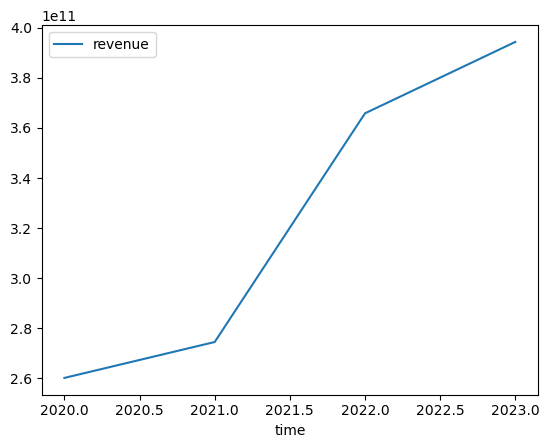

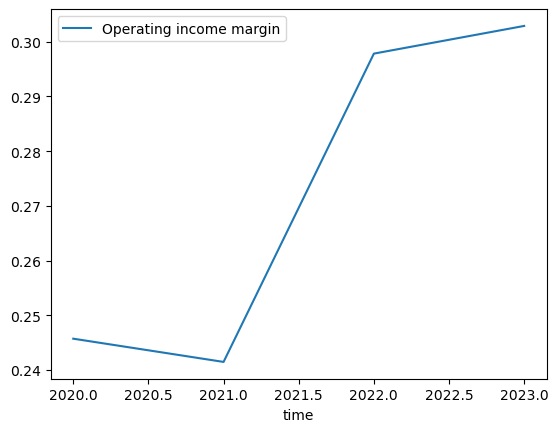

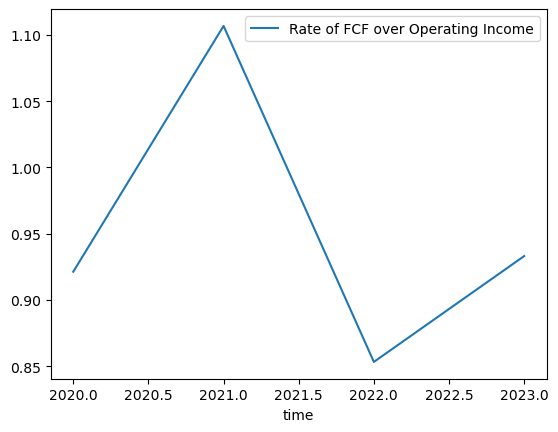

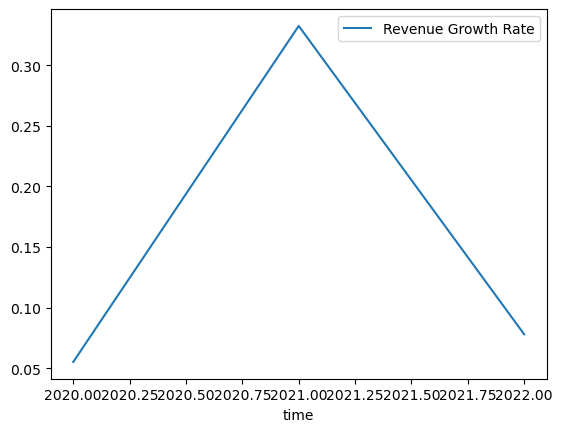

In [14]:
df_revenue=pd.DataFrame({'time':time_list,'revenue':revenue_list})
df_Operating_Income_Margin=pd.DataFrame({'time':time_list,'Operating income margin':Operating_Income_Margin_list})
df_FCF_OI_Rate=pd.DataFrame({'time':time_list,'Rate of FCF over Operating Income':FCF_Operating_Income_Rate_list})
time_list2=time_list.copy()
time_list2.remove(time_list2[-1])
df_growth_rate=pd.DataFrame({'time':time_list2,'Revenue Growth Rate':growth_rate_list})

df_revenue.plot(x='time',y='revenue')
df_Operating_Income_Margin.plot(x='time',y='Operating income margin')
df_FCF_OI_Rate.plot(x='time',y='Rate of FCF over Operating Income')
df_growth_rate.plot(x='time',y='Revenue Growth Rate')